In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df_emissions_raw = pd.read_csv('./data/Emissions_de_GEH_a_Catalunya_20250127.csv', sep=',', decimal='.')
df_emissions_raw.sample(2)

,ANY,PROVINCIA,ACTIVITAT,IPCC_SECTOR,IPCC_DIVISIO,IPCC_CLASSE,IPCC_SUBCLASSE,NOM_SECTOR,NOM_DIVISIO,NOM_CLASSE,NOM_SUBCLASSE,CONTAMINANT,UNITATS,CO2EQ,EMISSIO GAS
13101,1999,LLEIDA,1A5b,1,A,5.0,b,Processament de l'energia,Activitats de combustió,Altres,Fonts mòbils no especificades,N2O,Gg,0.003952,0.000015
10585,2017,GIRONA,1A2g,1,A,2.0,g,Processament de l'energia,Activitats de combustió,Indústries manufactureres i de la construcció,Altres sectors manufacturers i de la construcció,CH4,Gg,5.188145,0.185291


In [3]:
df_emissions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ANY             23486 non-null  int64  
 1   PROVINCIA       23486 non-null  object 
 2   ACTIVITAT       23486 non-null  object 
 3   IPCC_SECTOR     23486 non-null  int64  
 4   IPCC_DIVISIO    23486 non-null  object 
 5   IPCC_CLASSE     23222 non-null  float64
 6   IPCC_SUBCLASSE  21795 non-null  object 
 7   NOM_SECTOR      23486 non-null  object 
 8   NOM_DIVISIO     23486 non-null  object 
 9   NOM_CLASSE      23486 non-null  object 
 10  NOM_SUBCLASSE   23420 non-null  object 
 11  CONTAMINANT     23486 non-null  object 
 12  UNITATS         23486 non-null  object 
 13  CO2EQ           23486 non-null  float64
 14  EMISSIO GAS     23486 non-null  float64
dtypes: float64(3), int64(2), object(10)
memory usage: 2.7+ MB


In [4]:
df_emissions = df_emissions_raw.groupby(['ANY', 'CONTAMINANT'])['CO2EQ'].sum().unstack()

df_emissions['Other gases'] = df_emissions.drop(columns=['CO2', 'CH4', 'N2O'], errors='raise').sum(axis=1)
df_emissions['Total emissions'] = df_emissions[['CO2', 'CH4', 'N2O', 'Other gases']].sum(axis=1)
df_emissions = df_emissions[['CO2', 'CH4', 'N2O', 'Other gases', 'Total emissions']]
df_emissions.index.name = 'Year'

df_emissions.sample(2)

CONTAMINANT,CO2,CH4,N2O,Other gases,Total emissions
Year,,,,,
2002,34904.279687,7108.208564,1409.047494,1090.033341,44511.569086
1991,26011.810956,5870.054213,1179.698817,1836.643826,34898.207812


In [5]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1990 to 2022
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CO2              33 non-null     float64
 1   CH4              33 non-null     float64
 2   N2O              33 non-null     float64
 3   Other gases      33 non-null     float64
 4   Total emissions  33 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [6]:
df_emissions.describe()

CONTAMINANT,CO2,CH4,N2O,Other gases,Total emissions
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,31325.554548,6307.604570,1317.671031,2479.800675,41430.630825
std,4803.284524,490.917798,114.603041,1309.348651,5522.160232
min,25065.077518,5406.389064,1163.452978,819.979776,34053.042761
25%,27454.146921,5925.402693,1220.261155,1426.725346,36365.007181
50%,30145.129078,6200.813051,1280.864603,2401.912087,41381.849333
75%,34086.952676,6645.697158,1432.518715,2859.053866,45141.408648
max,41759.780690,7389.716448,1551.455543,5944.170230,51619.921170


In [7]:
df_production_raw = pd.read_excel('./data/SERIE-BALANC-1990-2022-web.xlsx', sheet_name='Producció Primària', skiprows=6, skipfooter=48)

df_production_raw

,Unnamed: 0,Unnamed: 1,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Carbó,NaN,170.400000,198.600000,142.800000,147.000000,159.000000,135.300000,137.800000,142.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Petroli,NaN,686.800000,980.900000,1012.100000,848.900000,802.300000,647.900000,503.300000,371.500000,...,369.889867,306.283887,228.098055,136.114963,121.624783,87.900978,35.782185,25.855087,4.838212,0.000000
2,Gas natural,NaN,2.300000,2.300000,2.200000,2.300000,2.100000,2.100000,1.800000,1.700000,...,1.324408,1.025533,1.618508,1.406425,2.200025,1.473368,0.667456,0.516586,0.130817,0.000000
3,Nuclear,NaN,5674.896900,5642.749530,5602.039272,5540.879403,5712.643503,5406.786216,5806.025910,5837.554710,...,6439.498618,6184.681921,6329.176776,6438.113236,6580.831378,5716.463005,6407.385337,6485.198560,6360.907818,6523.836994
4,Residus industrials no renovables,NaN,32.650000,39.971622,45.948462,47.485972,50.491684,65.567164,70.231202,79.793316,...,161.069393,180.527327,199.149262,209.702990,210.775850,176.009430,201.854500,192.566837,215.715359,200.359445
5,Energies renovables,NaN,484.277026,563.743324,652.274498,547.739964,539.805751,497.465693,659.620063,607.274901,...,1293.276358,1262.039610,1206.591979,1183.342564,1245.229041,1400.509734,1301.669451,1443.911561,1394.594593,1382.670164
6,NaN,Solar,1.200000,1.300000,1.300000,1.300000,1.300000,1.300000,1.400000,1.406517,...,70.002270,73.600679,76.082178,75.543758,77.595226,74.520571,79.207881,86.230451,97.606074,123.177894
7,NaN,Eòlica,0.003870,0.061892,0.062522,0.080549,0.119699,0.343761,0.708830,0.603061,...,280.696403,252.327821,228.629774,235.247253,248.153255,237.999387,268.191814,224.765895,230.903751,216.817770
8,NaN,Hidràulica,250.923156,295.781432,405.232748,353.072837,384.424080,333.378003,494.661808,447.910058,...,471.112715,457.334231,384.719328,345.248079,323.273772,468.672347,301.357923,442.422617,294.068063,233.503861
9,NaN,Biomassa forestal i agrària,211.500000,239.300000,211.600000,156.700000,115.600000,110.200000,108.500000,95.700000,...,222.273839,241.340586,242.903912,229.351127,263.350326,279.290557,272.146711,288.965213,318.659910,332.296629


In [8]:
df_production_raw = df_production_raw.T
df_production_raw.iloc[1, [0, 1, 2, 3, 4, 5, 14]] = df_production_raw.iloc[0, [0, 1, 2, 3, 4, 5, 14]]
df_production_raw = df_production_raw[1:]
df_production_raw.columns = df_production_raw.iloc[0]
df_production_raw = df_production_raw[1:]
df_production_raw.index.name = 'Year'

df_production_raw.head(2)

Unnamed: 1,Carbó,Petroli,Gas natural,Nuclear,Residus industrials no renovables,Energies renovables,Solar,Eòlica,Hidràulica,Biomassa forestal i agrària,Residus renovables,Biogàs,Biocarburants,Calor ambient,TOTAL
Year,,,,,,,,,,,,,,,
1990,170.4,686.8,2.3,5674.8969,32.65,484.277026,1.2,0.00387,250.923156,211.5,20.65,0.0,0.0,0.0,7051.323926
1991,198.6,980.9,2.3,5642.74953,39.971622,563.743324,1.3,0.061892,295.781432,239.3,27.3,0.0,0.0,0.0,7428.264476


In [9]:
df_production_raw['Energies no renovables'] = df_production_raw[['Carbó', 'Petroli', 'Gas natural', 'Nuclear', 'Residus industrials no renovables']].sum(axis=1)

prod_order_and_names = {'Carbó': 'Coal', 'Petroli': 'Oil', 'Gas natural': 'Natural gas', 'Nuclear': 'Nuclear', 'Residus industrials no renovables': 'Non-renewable industrial waste', 'Energies no renovables': 'Non-renewable energy', 'Solar': 'Solar', 'Eòlica': 'Wind power', 'Hidràulica': 'Hydraulics', 'Biomassa forestal i agrària': 'Forest and agricultural biomass', 'Residus renovables': 'Renewable waste', 'Biogàs': 'Biogas', 'Biocarburants': 'Biofuels', 'Calor ambient': 'Ambient heat', 'Energies renovables': 'Renewable energy', 'TOTAL': 'TOTAL'}
df_production_raw = df_production_raw.rename(columns=prod_order_and_names)[prod_order_and_names.values()]

df_production_raw.head(2)

Unnamed: 1,Coal,Oil,Natural gas,Nuclear,Non-renewable industrial waste,Non-renewable energy,Solar,Wind power,Hydraulics,Forest and agricultural biomass,Renewable waste,Biogas,Biofuels,Ambient heat,Renewable energy,TOTAL
Year,,,,,,,,,,,,,,,,
1990,170.4,686.8,2.3,5674.8969,32.65,6567.0469,1.2,0.00387,250.923156,211.5,20.65,0.0,0.0,0.0,484.277026,7051.323926
1991,198.6,980.9,2.3,5642.74953,39.971622,6864.521152,1.3,0.061892,295.781432,239.3,27.3,0.0,0.0,0.0,563.743324,7428.264476


In [10]:
df_production_raw = df_production_raw.apply(pd.to_numeric, errors='raise').astype(float)

df_production_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1990 to 2022
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Coal                             33 non-null     float64
 1   Oil                              33 non-null     float64
 2   Natural gas                      33 non-null     float64
 3   Nuclear                          33 non-null     float64
 4   Non-renewable industrial waste   33 non-null     float64
 5   Non-renewable energy             33 non-null     float64
 6   Solar                            33 non-null     float64
 7   Wind power                       33 non-null     float64
 8   Hydraulics                       33 non-null     float64
 9   Forest and agricultural biomass  33 non-null     float64
 10  Renewable waste                  33 non-null     float64
 11  Biogas                           33 non-null     float64
 12  Biofuels                

In [11]:
df_production_raw.describe()

Unnamed: 1,Coal,Oil,Natural gas,Nuclear,Non-renewable industrial waste,Non-renewable energy,Solar,Wind power,Hydraulics,Forest and agricultural biomass,Renewable waste,Biogas,Biofuels,Ambient heat,Renewable energy,TOTAL
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,70.295423,316.682016,1.585159,6063.804999,134.243235,6586.610832,33.814608,99.418486,362.199002,170.156609,74.613213,30.844313,18.246192,52.451229,841.743652,7428.354484
std,62.008869,283.603130,0.626524,450.878460,59.194307,426.318735,37.729359,109.109619,72.473719,79.562798,27.777033,25.812851,17.832909,80.841687,342.817657,552.123723
min,0.000000,0.000000,0.000000,5033.815067,32.650000,5321.745051,1.200000,0.003870,233.503861,80.700000,20.650000,0.000000,0.000000,0.000000,483.510125,6114.004087
25%,0.000000,121.624783,1.319633,5677.042424,79.793316,6483.091840,1.406517,0.726958,301.357923,95.700000,57.773666,0.365216,0.000000,0.000000,555.794397,7051.323926
50%,75.181440,228.098055,1.700000,6184.681921,153.855106,6672.518667,8.472007,27.270441,353.072837,144.186044,70.454413,39.538607,24.744478,0.000000,668.455625,7487.761903
75%,116.100000,371.500000,2.100000,6439.498618,180.527327,6836.134986,73.600679,228.629774,422.828728,239.300000,99.162936,54.658829,27.185415,72.817404,1206.591979,7934.558277
max,198.600000,1012.100000,2.463570,6696.378864,215.715359,7221.786512,123.177894,280.696403,494.661808,332.296629,124.503403,68.800326,58.296790,267.590504,1443.911561,8265.058644


In [12]:
df_production = df_production_raw[['Non-renewable energy', 'Renewable energy', 'TOTAL']].rename(columns={'Non-renewable energy': 'Non-renewable energy production', 'Renewable energy': 'Renewable energy production', 'TOTAL': 'Total production'})

df_production.sample(2)

Unnamed: 1,Non-renewable energy production,Renewable energy production,Total production
Year,,,
2013,6971.782286,1293.276358,8265.058644
2004,6836.134986,668.455625,7504.590612


In [13]:
df_production.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1990 to 2022
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Non-renewable energy production  33 non-null     float64
 1   Renewable energy production      33 non-null     float64
 2   Total production                 33 non-null     float64
dtypes: float64(3)
memory usage: 1.0+ KB


In [14]:
df_production.describe()

Unnamed: 1,Non-renewable energy production,Renewable energy production,Total production
count,33.000000,33.000000,33.000000
mean,6586.610832,841.743652,7428.354484
std,426.318735,342.817657,552.123723
min,5321.745051,483.510125,6114.004087
25%,6483.091840,555.794397,7051.323926
50%,6672.518667,668.455625,7487.761903
75%,6836.134986,1206.591979,7934.558277
max,7221.786512,1443.911561,8265.058644


In [15]:
df_consumption_raw = pd.read_excel('./data/SERIE-BALANC-1990-2022-web.xlsx', sheet_name='Consum Primària', skiprows=6, skipfooter=51)

df_consumption_raw

,Unnamed: 0,Unnamed: 1,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Carbó,NaN,565.100000,480.800000,315.900825,250.000443,266.098134,237.099602,297.499248,341.799809,...,31.705589,31.894019,30.994070,29.841760,36.697930,30.908310,28.328920,28.044570,35.602500,34.961660
1,Petroli,NaN,8428.933670,8811.013935,8945.177316,9310.302905,9565.084192,10090.362072,10558.652751,10238.482944,...,8912.809600,9443.924635,10208.250492,10285.410187,10468.261005,10679.582843,10524.743949,9209.386912,9467.116426,10279.680273
2,Gas natural,NaN,1749.200000,1891.333448,2013.555826,1887.665605,1991.220141,2215.740834,2505.530707,3206.531999,...,5545.105279,4929.092120,5252.957645,5203.474960,5608.683944,5522.718018,5808.666812,4939.054393,5189.081854,4984.371307
3,Nuclear,NaN,5674.896900,5642.749530,5602.039272,5540.879403,5712.643503,5406.786216,5806.025910,5837.554710,...,6439.498618,6184.681921,6329.176776,6438.113236,6580.831378,5716.463005,6407.385337,6485.198560,6360.907818,6523.836994
4,Saldo intercanvis elèctrics,NaN,144.730554,254.577733,100.755163,278.852126,245.893187,406.336418,113.854136,115.481820,...,143.310408,424.133145,409.554344,403.613967,324.239661,427.329857,129.322179,83.153068,385.403339,250.945542
5,Residus industrials no renovables,NaN,32.650000,39.971622,45.948462,47.485972,50.491684,65.567164,70.231202,79.793316,...,161.069393,180.527327,199.149262,209.702990,210.775850,176.009430,201.854500,192.566837,215.715359,200.359445
6,Energies renovables,NaN,484.277026,563.630820,652.180665,547.733647,539.703046,497.496435,659.539576,607.250179,...,1330.613297,1320.596481,1274.674260,1275.306562,1352.510533,1572.864719,1505.433877,1603.708124,1521.742454,1519.020826
7,NaN,Solar tèrmica,1.200000,1.300000,1.300000,1.300000,1.300000,1.300000,1.400000,1.400000,...,26.437834,27.185626,27.910172,28.736177,29.698346,30.667509,31.692529,32.951625,34.402197,35.745154
8,NaN,Solar fotovoltaica,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006517,...,37.130106,35.680112,36.485190,36.022060,36.889386,34.414768,38.829557,42.171202,51.807921,75.693358
9,NaN,Solar termoelèctrica,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.434330,10.734941,11.686816,10.785521,11.007495,9.438294,8.685794,11.107623,11.395956,11.739382


In [16]:
df_consumption_raw = df_consumption_raw.T
df_consumption_raw.iloc[1, [0, 1, 2, 3, 4, 5, 6, 17]] = df_consumption_raw.iloc[0, [0, 1, 2, 3, 4, 5, 6, 17]]
df_consumption_raw = df_consumption_raw[1:]
df_consumption_raw.columns = df_consumption_raw.iloc[0]
df_consumption_raw = df_consumption_raw[1:]
df_consumption_raw.index.name = 'Year'

df_consumption_raw.head(2)

Unnamed: 1,Carbó,Petroli,Gas natural,Nuclear,Saldo intercanvis elèctrics,Residus industrials no renovables,Energies renovables,Solar tèrmica,Solar fotovoltaica,Solar termoelèctrica,Eòlica,Hidràulica,"Biomassa agrària, animal i forestal",Residus renovables,Biogàs,Biocarburants,Calor ambient,TOTAL
Year,,,,,,,,,,,,,,,,,,
1990,565.1,8428.93367,1749.2,5674.8969,144.730554,32.65,484.277026,1.2,0.0,0.0,0.00387,250.923156,211.5,20.65,0.0,0.0,0.0,17079.788151
1991,480.8,8811.013935,1891.333448,5642.74953,254.577733,39.971622,563.63082,1.3,0.0,0.0,0.061892,295.781432,239.187497,27.3,0.0,0.0,0.0,17684.077087


In [17]:
df_consumption_raw['Energies no renovables'] = df_consumption_raw[['Carbó', 'Petroli', 'Gas natural', 'Nuclear', 'Saldo intercanvis elèctrics', 'Residus industrials no renovables']].sum(axis=1)

cons_order_and_names = {'Carbó': 'Coal', 'Petroli': 'Oil', 'Gas natural': 'Natural gas', 'Nuclear': 'Nuclear', 'Saldo intercanvis elèctrics': 'Electricity exchange balance', 'Residus industrials no renovables': 'Non-renewable industrial waste', 'Energies no renovables': 'Non-renewable energy', 'Solar tèrmica': 'Solar thermal', 'Solar fotovoltaica': 'Solar photovoltaic', 'Solar termoelèctrica': 'Solar thermoelectric', 'Eòlica': 'Wind power', 'Hidràulica': 'Hydraulics', 'Biomassa agrària, animal i forestal': 'Agricultural, animal and forest biomass', 'Residus renovables': 'Renewable waste', 'Biogàs': 'Biogas', 'Biocarburants': 'Biofuels', 'Calor ambient': 'Ambient heat', 'Energies renovables': 'Renewable energy', 'TOTAL': 'TOTAL'}
df_consumption_raw = df_consumption_raw.rename(columns=cons_order_and_names)[cons_order_and_names.values()]

df_consumption_raw.head(2)

Unnamed: 1,Coal,Oil,Natural gas,Nuclear,Electricity exchange balance,Non-renewable industrial waste,Non-renewable energy,Solar thermal,Solar photovoltaic,Solar thermoelectric,Wind power,Hydraulics,"Agricultural, animal and forest biomass",Renewable waste,Biogas,Biofuels,Ambient heat,Renewable energy,TOTAL
Year,,,,,,,,,,,,,,,,,,,
1990,565.1,8428.93367,1749.2,5674.8969,144.730554,32.65,16595.511124,1.2,0.0,0.0,0.00387,250.923156,211.5,20.65,0.0,0.0,0.0,484.277026,17079.788151
1991,480.8,8811.013935,1891.333448,5642.74953,254.577733,39.971622,17120.446267,1.3,0.0,0.0,0.061892,295.781432,239.187497,27.3,0.0,0.0,0.0,563.63082,17684.077087


In [18]:
df_consumption_raw = df_consumption_raw.apply(pd.to_numeric, errors='raise').astype(float)

df_consumption_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1990 to 2022
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Coal                                     33 non-null     float64
 1   Oil                                      33 non-null     float64
 2   Natural gas                              33 non-null     float64
 3   Nuclear                                  33 non-null     float64
 4   Electricity exchange balance             33 non-null     float64
 5   Non-renewable industrial waste           33 non-null     float64
 6   Non-renewable energy                     33 non-null     float64
 7   Solar thermal                            33 non-null     float64
 8   Solar photovoltaic                       33 non-null     float64
 9   Solar thermoelectric                     33 non-null     float64
 10  Wind power                               33 non-null

In [19]:
df_consumption_raw.describe()

Unnamed: 1,Coal,Oil,Natural gas,Nuclear,Electricity exchange balance,Non-renewable industrial waste,Non-renewable energy,Solar thermal,Solar photovoltaic,Solar thermoelectric,Wind power,Hydraulics,"Agricultural, animal and forest biomass",Renewable waste,Biogas,Biofuels,Ambient heat,Renewable energy,TOTAL
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,184.106127,10557.023416,4606.445237,6063.804999,346.846794,134.243235,21892.469807,13.886477,16.806429,3.121702,99.418486,362.199002,144.852520,74.613213,30.844313,101.024091,52.451229,899.217463,22791.687270
std,141.057679,1171.996884,1612.948721,450.878460,192.261069,59.194307,2700.783554,13.083392,20.706241,4.888483,109.109619,72.473719,55.973527,27.777033,25.812851,111.814135,80.841687,405.988262,2795.491027
min,28.044570,8428.933670,1749.200000,5033.815067,83.153068,32.650000,16595.511124,1.200000,0.000000,0.000000,0.003870,233.503861,80.690000,20.650000,0.000000,0.000000,0.000000,482.800125,17079.788151
25%,34.961660,9565.084192,3206.531999,5677.042424,212.571765,79.793316,20937.404340,1.400000,0.003978,0.000000,0.726958,301.357923,95.675278,57.773666,0.365216,0.000000,0.000000,542.808651,21492.951887
50%,209.413128,10524.743949,5189.081854,6184.681921,336.484112,153.855106,22376.691175,7.831683,0.640325,0.000000,27.270441,353.072837,118.054044,70.454413,39.538607,28.020828,0.000000,660.830013,23704.756850
75%,267.075003,11265.078036,5921.607633,6439.498618,423.476613,180.527327,23238.628948,27.185626,35.680112,8.685794,228.629774,422.828728,192.312954,99.162936,54.658829,206.272361,72.817404,1275.306562,24605.735573
max,565.100000,12571.711855,6719.985089,6696.378864,826.421046,215.715359,25746.971292,35.745154,75.693358,11.739382,280.696403,494.661808,253.522119,124.503403,68.800326,331.136652,267.590504,1603.708124,26350.873978


In [20]:
df_consumption = df_consumption_raw[['Non-renewable energy', 'Renewable energy', 'TOTAL']].rename(columns={'Non-renewable energy': 'Non-renewable energy consumption', 'Renewable energy': 'Renewable energy consumption', 'TOTAL': 'Total consumption'})

df_consumption.sample(2)

Unnamed: 1,Non-renewable energy consumption,Renewable energy consumption,Total consumption
Year,,,
2017,23229.489767,1352.510533,24582.000300
2011,22939.030805,1140.363261,24079.394066


In [21]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1990 to 2022
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Non-renewable energy consumption  33 non-null     float64
 1   Renewable energy consumption      33 non-null     float64
 2   Total consumption                 33 non-null     float64
dtypes: float64(3)
memory usage: 1.0+ KB


In [22]:
df_consumption.describe()

Unnamed: 1,Non-renewable energy consumption,Renewable energy consumption,Total consumption
count,33.000000,33.000000,33.000000
mean,21892.469807,899.217463,22791.687270
std,2700.783554,405.988262,2795.491027
min,16595.511124,482.800125,17079.788151
25%,20937.404340,542.808651,21492.951887
50%,22376.691175,660.830013,23704.756850
75%,23238.628948,1275.306562,24605.735573
max,25746.971292,1603.708124,26350.873978


In [23]:
df_concated = pd.concat([df_production, df_consumption, df_emissions], axis=1)

df_concated

,Non-renewable energy production,Renewable energy production,Total production,Non-renewable energy consumption,Renewable energy consumption,Total consumption,CO2,CH4,N2O,Other gases,Total emissions
Year,,,,,,,,,,,
1990,6567.046900,484.277026,7051.323926,16595.511124,484.277026,17079.788151,25065.077518,6125.122896,1175.864876,1686.977471,34053.042761
1991,6864.521152,563.743324,7428.264476,17120.446267,563.630820,17684.077087,26011.810956,5870.054213,1179.698817,1836.643826,34898.207812
1992,6805.087734,652.274498,7457.362232,17023.376864,652.180665,17675.557529,26575.781971,5925.402693,1182.265898,2829.312994,36512.763555
1993,6586.565375,547.739964,7134.305339,17315.186455,547.733647,17862.920103,25361.790976,6016.370088,1220.261155,2408.546160,35006.968379
1994,6726.535187,539.805751,7266.340938,17831.430841,539.703046,18371.133887,27865.885286,6316.920888,1432.518715,3228.750819,38844.075708
1995,6257.653380,497.465693,6755.119072,18421.892305,497.496435,18919.388739,32196.421925,6541.270308,1432.630040,3963.214530,44133.536804
1996,6519.157112,659.620063,7178.777175,19351.793953,659.539576,20011.333529,30487.592661,6675.632163,1551.455543,4310.813698,43025.494065
1997,6432.948026,607.274901,7040.222927,19819.644598,607.250179,20426.894776,30145.129078,6683.473045,1472.645483,4565.527652,42866.775258
1998,6976.112830,542.741251,7518.854081,20950.143236,542.808651,21492.951887,30923.605763,6768.570160,1486.132311,4139.491445,43317.799680


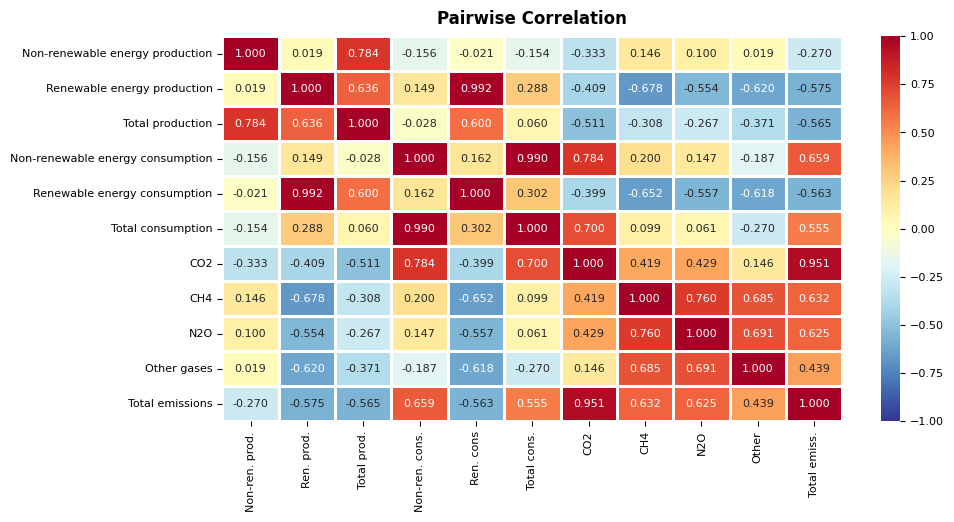

In [62]:
ticklabels = ['Non-ren. prod.', 'Ren. prod.', 'Total prod.', 'Non-ren. cons.', 'Ren. cons', 'Total cons.', 'CO2', 'CH4', 'N2O', 'Other', 'Total emiss.']

correlation_matrix = df_concated.corr()

fig, ax = plt.subplots(figsize=(10, 5))

heatmap = sns.heatmap(
    correlation_matrix,
    vmin=-1,
    vmax=1,
    cmap='RdYlBu_r',
    annot=True,
    annot_kws={'size': 8},
    fmt='.3f',
    cbar=True,
    linewidths=1,
    xticklabels=ticklabels,
    ax=ax
)

ax.set_title('Pairwise Correlation', fontweight='bold', verticalalignment='bottom')
ax.tick_params(labelsize=8)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

plt.show()

#### Hypothesis 1: Does increasing renewable energy production contribute to reducing emissions?

In [25]:
x = df_concated['Renewable energy production']
y = df_concated['Total emissions']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f'equation: y = {slope:.2f}x + {intercept:.2f}\n')
print(f'slope: {slope:.2f}')
print(f'intercept: {intercept:.2f}')
print(f'standart error: {std_err:.2f}\n')
print(f'correlation: {r_value:.5}')
print(f'p-value: {p_value:.5f}\n')

if p_value < 0.05:
    print('Yes, the dependence is significant')
else:
    print('No, the dependence is not significant')

equation: y = -9.26x + 49225.32

slope: -9.26
intercept: 49225.32
standart error: 2.37

correlation: -0.57487
p-value: 0.00047

Yes, the dependence is significant


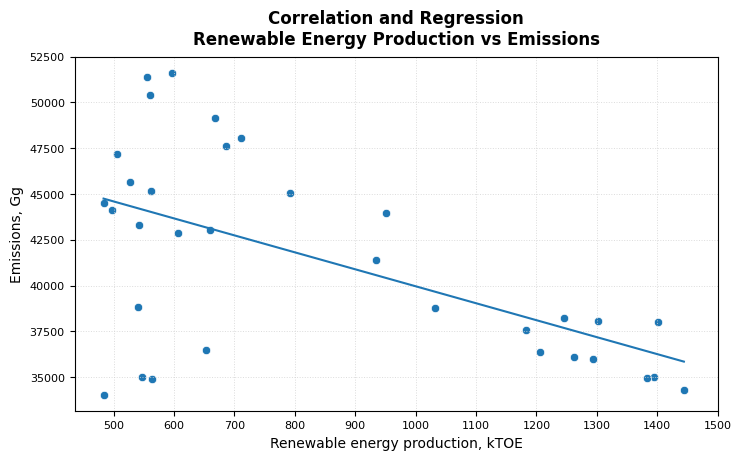

In [26]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

x_fit = np.linspace(min(x), max(x))
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit)

sns.scatterplot(
    x=df_concated['Renewable energy production'],
    y=df_concated['Total emissions'],
    ax=ax
)

ax.set_title(f'Correlation and Regression\nRenewable Energy Production vs Emissions', fontweight='bold', verticalalignment='bottom')
ax.set_xlabel('Renewable energy production, kTOE')
ax.set_ylabel('Emissions, Gg')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_xticks(range(500, 1501, 100))
ax.set_yticks(range(35000, 52501, 2500))

plt.show()

#### Hypothesis 2: How much renewable energy do we need producing to reduce emissions by 32% compared to 1990 levels?

In [27]:
based_emissons = df_concated['Total emissions'].iloc[0]
target_emissons = based_emissons * 0.68

predicted_production = (target_emissons - intercept) / slope

print(f'To reduce emissions by 32% compared to 1990 levels, renewable energy production needs to increase to: {predicted_production:.2f}')

To reduce emissions by 32% compared to 1990 levels, renewable energy production needs to increase to: 2815.20


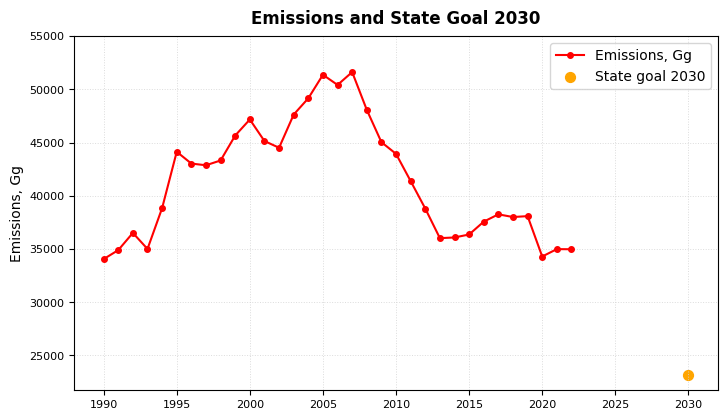

In [46]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

ax.plot(
    df_concated.index, 
    df_concated['Total emissions'], 
    marker='o',
    markersize=4,
    linestyle='-',
    color='red', 
    label='Emissions, Gg'
)

ax.scatter(
    2030,
    target_emissons, 
    color='orange', 
    s=50, 
    label=f'State goal 2030'
)

ax.set_title(f'Emissions and State Goal 2030', fontweight='bold', verticalalignment='bottom')
ax.set_ylabel('Emissions, Gg')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range(25000, 55001, 5000))
ax.legend()

plt.show()

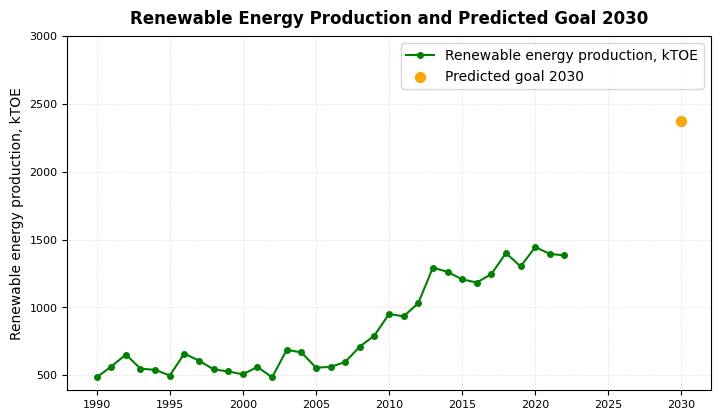

In [48]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

ax.plot(
    df_concated.index, 
    df_concated['Renewable energy production'], 
    marker='o',
    markersize=4,
    linestyle='-',
    color='green',
    label='Renewable energy production, kTOE'
)

ax.scatter(
    2030,
    predicted_production, 
    color='orange', 
    s=50, 
    label='Predicted goal 2030'
)

ax.set_title(f'Renewable Energy Production and Predicted Goal 2030', fontweight='bold', verticalalignment='bottom')
ax.set_ylabel('Renewable energy production, kTOE')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range(500, 3001, 500))
ax.legend()

plt.show()

#### Hypothesis 3: Is it possible to reduce emissions by 32% compared to 1990 levels by reducing consumption alone without increasing renewable energy production?

In [49]:
x = df_concated['Total consumption']
y = df_concated['Total emissions']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f'equation: y = {slope:.2f}x + {intercept:.2f}\n')
print(f'slope: {slope:.2f}')
print(f'intercept: {intercept:.2f}')
print(f'standart error: {std_err:.2f}\n')
print(f'correlation: {r_value:.5f}')
print(f'p-value: {p_value:.5f}\n')

if p_value < 0.05:
    print('Yes, the dependence is significant')
else:
    print('No, the dependence is not significant')

equation: y = 1.10x + 16458.06

slope: 1.10
intercept: 16458.06
standart error: 0.30

correlation: 0.55467
p-value: 0.00081

Yes, the dependence is significant


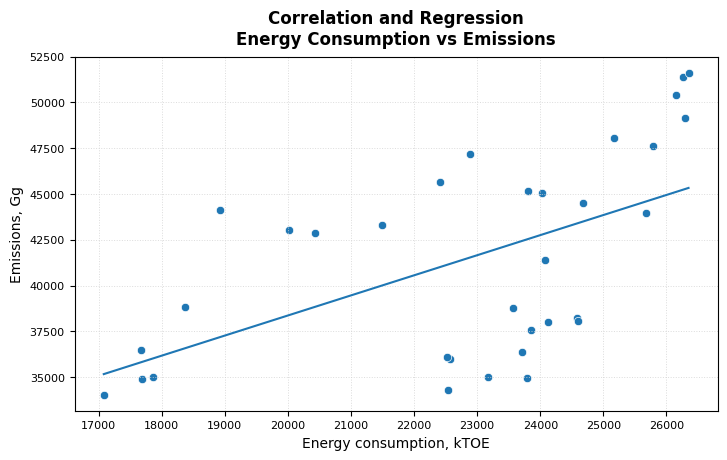

In [31]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

x_fit = np.linspace(min(x), max(x))
y_fit = slope * x_fit + intercept

ax.plot(x_fit, y_fit)

sns.scatterplot(
    x=df_concated['Total consumption'],
    y=df_concated['Total emissions'],
    ax=ax
)

ax.set_title(f'Correlation and Regression\nEnergy Consumption vs Emissions', fontweight='bold', verticalalignment='bottom')
ax.set_xlabel('Energy consumption, kTOE')
ax.set_ylabel('Emissions, Gg')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_xticks(range(17000, 27000, 1000))
ax.set_yticks(range(35000, 52501, 2500))

plt.show()

In [32]:
predicted_production = (target_emissons - intercept) / slope

print(f'To reduce emissions by 32% compared to 1990 levels, energy consumption would need to be reduced to: {predicted_production:.2f}')

To reduce emissions by 32% compared to 1990 levels, energy consumption would need to be reduced to: 6113.07


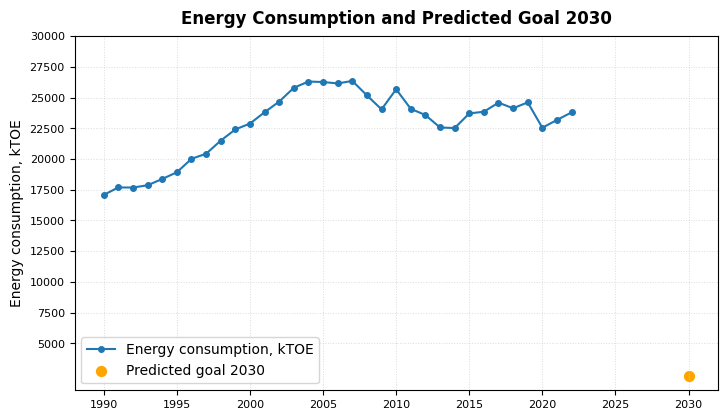

In [50]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

ax.plot(
    df_concated.index, 
    df_concated['Total consumption'], 
    marker='o',
    markersize=4,
    linestyle='-', 
    label='Energy consumption, kTOE'
)

ax.scatter(
    2030,
    predicted_production, 
    color='orange', 
    s=50, 
    label='Predicted goal 2030'
)

ax.set_title(f'Energy Consumption and Predicted Goal 2030', fontweight='bold', verticalalignment='bottom')
ax.set_ylabel('Energy consumption, kTOE')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range(5000, 30001, 2500))
ax.legend(loc='lower left')

plt.show()

#### Hypothesis 4: How much renewable energy do we need to produce to cut emissions by 32% below 1990 levels without reducing consumption?

In [34]:
X = df_concated[['Renewable energy production', 'Total consumption']]
y = df_concated['Total emissions']

model = LinearRegression()
model.fit(X, y)

beta_0 = model.intercept_
beta_1, beta_2 = model.coef_
r_value = model.score(X, y)

print(f'equation: y = {beta_1:.2f}x1 + {beta_2:.2f}x2 + {beta_0:.2f}\n')
print(f'intercept (beta_0): {beta_0:.4f}')
print(f'coef of Renewable energy production (beta_1): {beta_1:.4f}')
print(f'coef of Consumption (beta_2): {beta_2:.4f}')
print(f'correlation: {r_value:.5f}')

equation: y = -12.91x1 + 1.55x2 + 16918.61

intercept (beta_0): 16918.6109
coef of Renewable energy production (beta_1): -12.9108
coef of Consumption (beta_2): 1.5523
correlation: 0.89664


In [35]:
X_with_const = sm.add_constant(X)
model_ols = sm.OLS(y, X_with_const).fit()

print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:        Total emissions   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     130.1
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.64e-15
Time:                        18:42:53   Log-Likelihood:                -293.22
No. Observations:                  33   AIC:                             592.4
Df Residuals:                      30   BIC:                             596.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [36]:
X_values = X_with_const.values
vif = [variance_inflation_factor(X_values, i) for i in range(X_values.shape[1])]
vif_data = pd.DataFrame({'Variable': X_with_const.columns, 'VIF': vif})

vif_data

,Variable,VIF
0,const,69.561114
1,Renewable energy production,1.090719
2,Total consumption,1.090719


In [37]:
current_consumption = df_consumption['Total consumption'].iloc[32]

predicted_production = (target_emissons - beta_0 - beta_2 * current_consumption) / beta_1

print(f'To reduce emissions by 32% compared to 1990 levels without reducing consumption, renewable energy production needs to increase to: {predicted_production:.2f}')

To reduce emissions by 32% compared to 1990 levels without reducing consumption, renewable energy production needs to increase to: 2377.61


In [70]:
reduced_consumption = current_consumption * 0.9

new_predicted_production = (target_emissons - beta_0 - beta_2 * reduced_consumption) / beta_1

print(f'If consumption is reduced by 10%, renewable energy production needs to increase to: {new_predicted_production:.2f}')

If consumption is reduced by 10%, renewable energy production needs to increase to: 2091.54


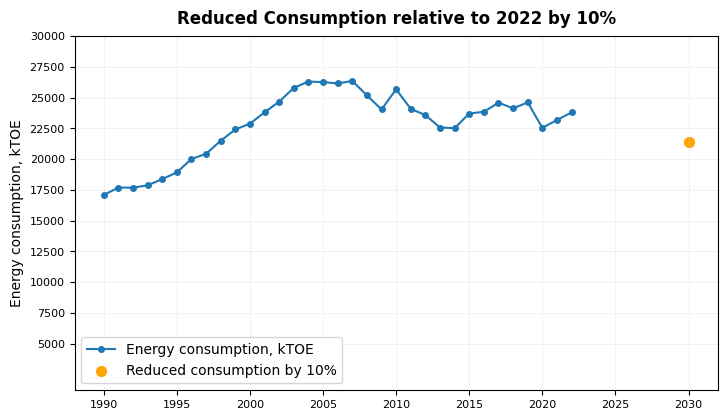

In [83]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

ax.plot(
    df_concated.index, 
    df_concated['Total consumption'], 
    marker='o',
    markersize=4,
    linestyle='-', 
    label='Energy consumption, kTOE'
)

ax.scatter(
    2030,
    reduced_consumption, 
    color='orange', 
    s=50, 
    label='Reduced consumption by 10%'
)

ax.set_title(f'Reduced Consumption relative to 2022 by 10%', fontweight='bold', verticalalignment='bottom')
ax.set_ylabel('Energy consumption, kTOE')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range(5000, 30001, 2500))
ax.set_ylim(1200, 30000)
ax.legend(loc='lower left')

plt.show()

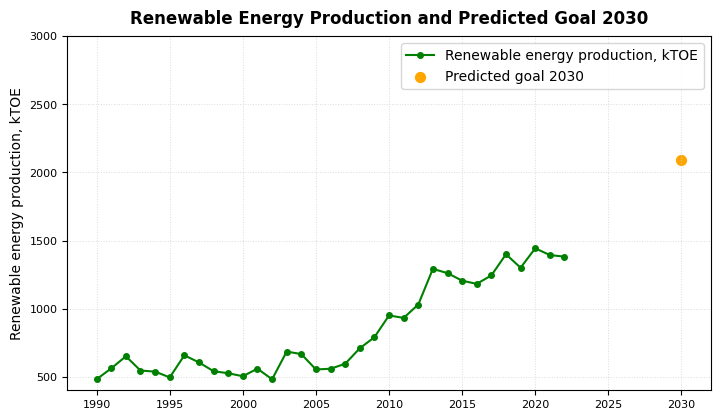

In [78]:
fig, ax = plt.subplots(figsize=(8.3, 4.6))

ax.plot(
    df_concated.index, 
    df_concated['Renewable energy production'], 
    marker='o',
    markersize=4,
    linestyle='-',
    color='green',
    label='Renewable energy production, kTOE'
)

ax.scatter(
    2030,
    new_predicted_production, 
    color='orange', 
    s=50, 
    label='Predicted goal 2030'
)

ax.set_title(f'Renewable Energy Production and Predicted Goal 2030', fontweight='bold', verticalalignment='bottom')
ax.set_ylabel('Renewable energy production, kTOE')
ax.grid(linestyle=':', color='lightgray', linewidth=0.7, alpha=0.8)
ax.tick_params(labelsize=8)
ax.set_yticks(range(500, 3001, 500))
ax.legend()

plt.show()

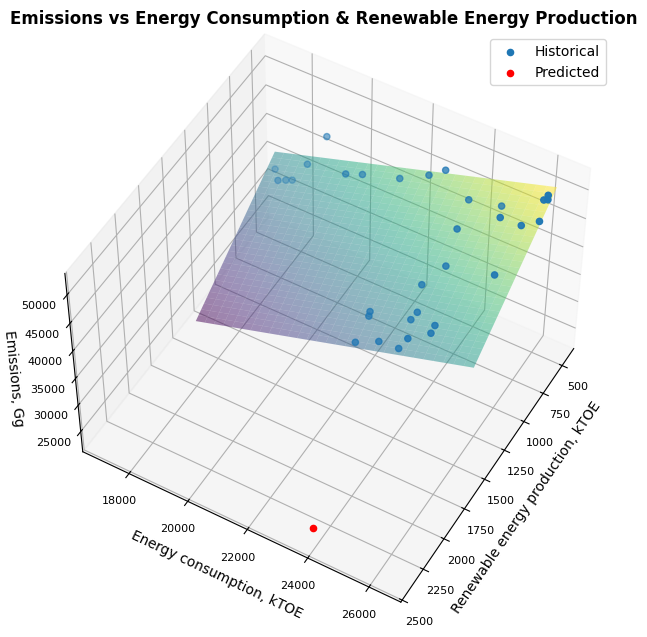

In [38]:
ren_range = np.linspace(X['Renewable energy production'].min(), X['Renewable energy production'].max(), 30)
cons_range = np.linspace(X['Total consumption'].min(), X['Total consumption'].max(), 30)
ren_grid, cons_grid = np.meshgrid(ren_range, cons_range)

em_pred = beta_0 + beta_1*ren_grid + beta_2*cons_grid

fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    ren_grid,
    cons_grid,
    em_pred,
    alpha=0.5,
    cmap='viridis'
)

ax.scatter(
    X['Renewable energy production'],
    X['Total consumption'],
    y,
    label='Historical'
)

ax.scatter(
    predicted_production,
    current_consumption,
    target_emissons,
    color='red',
    s=20,
    label='Predicted'
)

ax.set_title('Emissions vs Energy Consumption & Renewable Energy Production', fontweight='bold')
ax.set_xlabel('Renewable energy production, kTOE')
ax.set_ylabel('Energy consumption, kTOE')
ax.set_zlabel('Emissions, Gg')
ax.tick_params(labelsize=8)
ax.legend()

ax.view_init(elev=50, azim=30)

plt.show()

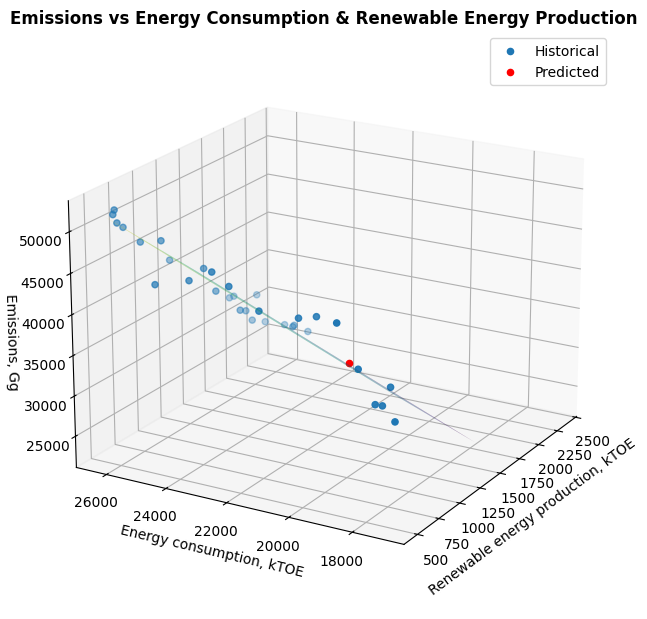

In [39]:
fig = plt.figure(figsize=(12, 7.5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    ren_grid,
    cons_grid,
    em_pred,
    alpha=0.5,
    cmap='viridis'
)

ax.scatter(
    X['Renewable energy production'],
    X['Total consumption'],
    y,
    label='Historical'
)

ax.scatter(
    predicted_production,
    current_consumption,
    target_emissons,
    color='red',
    s=20,
    label='Predicted'
)

ax.set_xlabel('Renewable energy production, kTOE')
ax.set_ylabel('Energy consumption, kTOE')
ax.set_zlabel('Emissions, Gg')
ax.set_title('Emissions vs Energy Consumption & Renewable Energy Production', fontweight='bold')
ax.legend()

ax.view_init(elev=20, azim=210)

plt.show()